# Prediction of Loan Payment using 10+ ML Models

# About df

## Purpose
The purpose of this notebook is to compare and evaluate the performance of different ML models in predicting whether a borrower will make loan payments on time or default. By training and testing the dataset on various algorithms, we aim to identify the most effective model for this specific prediction task.

## Context
This df set includes customers who have paid off their loans, who have been past due and put into collection without paying back their loan and interests, and who have paid off only after they were put in collection. The financial product is a bullet loan that customers should pay off all of their loan debt in just one time by the end of the term, instead of an installment schedule. Of course, they could pay off earlier than their pay schedule.

## Content
Loan_id A unique loan number assigned to each loan customers

Loan_status Whether a loan is paid off, in collection, new customer yet to payoff, or paid off after the collection efforts

Principal Basic principal loan amount at the origination

terms Can be weekly (7 days), biweekly, and monthly payoff schedule

Effective_date When the loan got originated and took effects

Due_date Since it’s one-time payoff schedule, each loan has one single due date

Paidoff_time The actual time a customer pays off the loan

Pastdue_days How many days a loan has been past due

Age, education, gender A customer’s basic demographic information

# Import Libraries

In [20]:
import numpy as np # linear algebra
import pandas as pd # df processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loandata/Loan payments data.csv


# Loading Data

In [21]:
df = pd.read_csv('/kaggle/input/loandata/Loan payments data.csv')

### Run this to Profile df

import pandas_profiling as pp
profile = pp.ProfileReport(    df, title="Campus Recruitment Profile", html={"style": {"full_width": True}}, sort=None)
profile

Data contains,

> 400 missing values 
> >     paid_off_time     100
> >     past_due_days     300


# Preprocessing

In [22]:
df.isna().sum()

Loan_ID             0
loan_status         0
Principal           0
terms               0
effective_date      0
due_date            0
paid_off_time     100
past_due_days     300
age                 0
education           0
Gender              0
dtype: int64

In [23]:
df['loan_status'].unique()

array(['PAIDOFF', 'COLLECTION', 'COLLECTION_PAIDOFF'], dtype=object)

In [24]:
{column: len(df[column].unique()) for column in df.columns}

{'Loan_ID': 500,
 'loan_status': 3,
 'Principal': 6,
 'terms': 3,
 'effective_date': 7,
 'due_date': 25,
 'paid_off_time': 321,
 'past_due_days': 34,
 'age': 33,
 'education': 4,
 'Gender': 2}

In [25]:
def binary_encode(df1, column, positive_value):
    df1 = df1.copy()
    df1[column] = df1[column].apply(lambda x: 1 if x == positive_value else 0)
    return df1

def ordinal_encode(df1, column, ordering):
    df1 = df1.copy()
    df1[column] = df1[column].apply(lambda x: ordering.index(x))
    return df1

In [26]:
    # Drop Loan_ID column
    df = df.drop('Loan_ID', axis=1)
    df

,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female
...,...,...,...,...,...,...,...,...,...,...
495,COLLECTION_PAIDOFF,1000,30,9/12/2016,10/11/2016,10/14/2016 19:08,3.0,28,High School or Below,male
496,COLLECTION_PAIDOFF,1000,15,9/12/2016,9/26/2016,10/10/2016 20:02,14.0,26,High School or Below,male
497,COLLECTION_PAIDOFF,800,15,9/12/2016,9/26/2016,9/29/2016 11:49,3.0,30,college,male
498,COLLECTION_PAIDOFF,1000,30,9/12/2016,11/10/2016,11/11/2016 22:40,1.0,38,college,female


In [27]:
    # Create date/time columns
    for column in ['effective_date', 'due_date', 'paid_off_time']:
        df[column] = pd.to_datetime(df[column])

In [28]:
df['effective_day'] = df['effective_date'].apply(lambda x: x.day)

df['due_month'] = df['due_date'].apply(lambda x: x.month)
df['due_day'] = df['due_date'].apply(lambda x: x.day)

df['paid_off_month'] = df['paid_off_time'].apply(lambda x: x.month)
df['paid_off_day'] = df['paid_off_time'].apply(lambda x: x.day)
df['paid_off_hour'] = df['paid_off_time'].apply(lambda x: x.hour)

df = df.drop(['effective_date', 'due_date', 'paid_off_time'], axis=1)

In [29]:
    # Fill missing values with column means
    for column in ['past_due_days', 'paid_off_month', 'paid_off_day', 'paid_off_hour']:
        df[column] = df[column].fillna(df[column].mean())
    

In [30]:
    # Binary encode the Gender column
    df = binary_encode(df, 'Gender', positive_value='male')
    

In [31]:
    # Ordinal encode the education column
    education_ordering = [
        'High School or Below',
        'college',
        'Bechalor',
        'Master or Above'
    ]
    df = ordinal_encode(df, 'education', ordering=education_ordering)
   

In [32]:
 
    # Encode the label (loan_status) column
    label_mapping = {'COLLECTION': 0, 'PAIDOFF': 1, 'COLLECTION_PAIDOFF': 2}
    df['loan_status'] = df['loan_status'].replace(label_mapping)
    

In [33]:
    # Split df into X and y
    y = df['loan_status'].copy()
    X = df.drop('loan_status', axis=1).copy()

In [34]:
    # Scale X with a standard scaler
    from sklearn.preprocessing import StandardScaler

    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    

 # Models

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.9, random_state=123)

Confusion matrix of  CatBoostClassifier
[[11  0  0]
 [ 0 32  0]
 [ 0  0  7]]
Accuracy score is  1.0
Confusion matrix of  Logistic Regression
[[10  1  0]
 [ 0 32  0]
 [ 0  0  7]]
Accuracy score is  0.98
Confusion matrix of  Support Vector Machine
[[11  0  0]
 [ 0 32  0]
 [ 0  0  7]]
Accuracy score is  1.0
Confusion matrix of  Decision Tree
[[11  0  0]
 [ 0 32  0]
 [ 0  0  7]]
Accuracy score is  1.0
Confusion matrix of  Neural Network
[[11  0  0]
 [ 0 32  0]
 [ 0  0  7]]
Accuracy score is  1.0
Confusion matrix of  Random Forest
[[11  0  0]
 [ 0 32  0]
 [ 0  0  7]]
Accuracy score is  1.0
[12:18:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion matrix of  XGBoost
[[11  0  0]
 [ 0 32  0]
 [ 0  0  7]]
Accuracy score is  1.0
Confusion matrix of  LGBMClassifier
[[11  0  0]
 [ 0 32  0]
 [ 0  

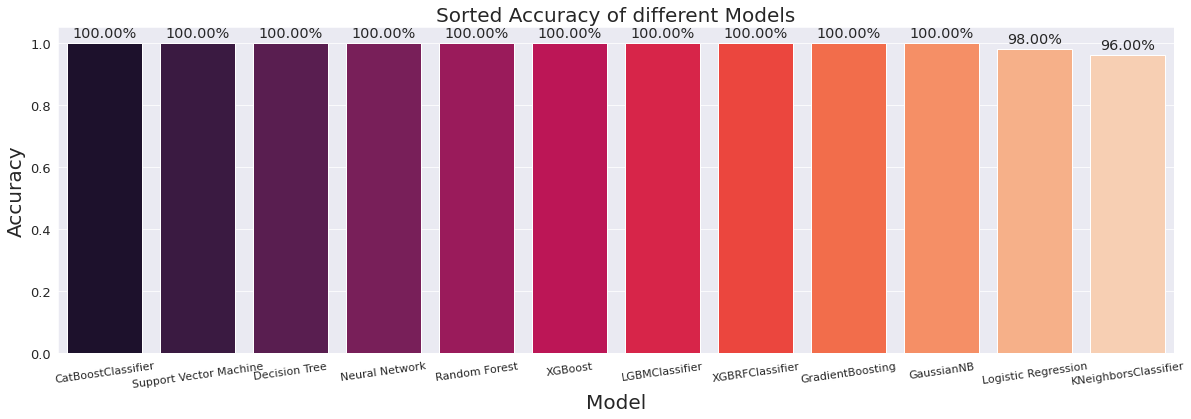

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm
import xgboost
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

names = [
    "CatBoostClassifier",
    "Logistic Regression",
    "Support Vector Machine",
    "Decision Tree",
    "Neural Network",
    "Random Forest",
    "XGBoost",
    "LGBMClassifier",
    "XGBRFClassifier",
    "GradientBoosting",
    "GaussianNB",
    "KNeighborsClassifier"
]
models = [
    CatBoostClassifier(verbose= False),
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    MLPClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    lightgbm.LGBMClassifier(max_depth=2, random_state=4),
    xgboost.XGBRFClassifier(max_depth=3, random_state=1),
    GradientBoostingClassifier(max_depth=2, random_state=1),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
]

accuracy=[]
for model, name in zip(models,names):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print('Confusion matrix of ',name)
    print(confusion_matrix(y_test, y_pred))
    ac = accuracy_score(y_test, y_pred)
    print('Accuracy score is ',ac)
    accuracy.append(ac)
    print('='*50)

Accuracy_list = pd.DataFrame(list(zip(names, accuracy)),columns =['Model', 'Accuracy'])
Accuracy_list= Accuracy_list.sort_values('Accuracy', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last', ignore_index=True, key=None)

plt.rcParams['figure.figsize']=20,6 
sns.set_style("darkgrid")
ax = sns.barplot(x = 'Model',y = 'Accuracy',data = Accuracy_list , palette = "rocket", saturation =1.5)
plt.xlabel("Model", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Sorted Accuracy of different Models", fontsize = 20)
plt.xticks(fontsize = 11, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()